# <font color='green'>Homework 3</font>

<div class="alert alert-block alert-warning">
<b>
University of Tehran<br>
Fall 2022<br>
Course: Interactive Learning<br>
</div>


***

<div class="alert alert-block alert-success">
<b>Author:</b><br>
Name: Taban Soleymani <br />
Student Number: 
</div>

***

# <span style="color:purple">Importing Required Packages and Classes</span>

In [1]:
import numpy as np
from abc import ABC
import seaborn
from gym import Env
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

# <span style="color:purple">Defining Variables</span>

In [2]:
global student_num
global LEFT
global DOWN 
global RIGHT 
global UP
student_num = xxx
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

# <span style="color:purple">Part 1</span>

## <span style="color:purple">Map</span>

In [3]:
def make_map(studentNum): 
    """
    Observation Space : map of environment 
    A 6*6 Grid Graph
    Start point = (0,0)
    End point = (5,5)
    Just one safe path for each Student number
    The probability of falling in each state:
    in safe path = 0.0001 and for other states = 1

    :param 1: Student number 
    
    :return : The Created Map 
    """

    np.random.seed(studentNum)  
    move = np.zeros(10)  # Minimum moves for start to the end point in a 6*6 grid graph
    idx = np.random.choice(range(10),size=5,replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]

    for m in move:
        if m:
            point[0] += 1
        else:
            point[1] += 1
        lowprobs.append(tuple(point))

    idx = np.array(lowprobs)
    map = np.ones((6,6))
    map[idx[:,0],idx[:,1]] = 0.0001  
    
    map[0,0] = 0.0   # Start point
    map[5,5] = 0.0   # End point

    return map

## <span style="color:purple">Frozen Lake</span>

In [50]:
class FrozenLake(Env):
    def __init__(self):
        self.observation_space = make_map(student_num)
        self.num_of_states = self.observation_space.shape[0] * self.observation_space.shape[1] - 2
        self.action_space = [LEFT,DOWN,RIGHT,UP]
        self.initial_state = 0
        self.current_state = 0
        self.nearest1_state_to_goal = self.observation_space.shape[0] * self.observation_space.shape[1] - 2
        self.nearest2_state_to_goal = self.observation_space.shape[0] * self.observation_space.shape[1] - self.observation_space.shape[1] - 1
        self.failure_prob = 0.06
        self.has_episode_finished = False
        

    def reset(self):
        self.has_episode_finished = False
        self.current_state = self.initial_state 
        return self.current_state
    

    def step(self, action):
        if self.has_episode_finished:
            print('you should restart the env!')
            return self.current_state, 0, self.has_episode_finished
        
        has_been_reached_to_broken = False
        has_been_reached_to_goal = False
        
        probability_of_action = 1 - self.failure_prob
        prob = [1/(len(self.action_space)-1)] * (len(self.action_space)-1)
        rnd_num = np.random.random()
        if rnd_num<=self.failure_prob:
            if action == LEFT:
                action = np.random.choice([DOWN, RIGHT, UP], p=prob)
                probability_of_action = self.failure_prob / (len(self.action_space)-1)
            elif action == DOWN:
                action = np.random.choice([LEFT, RIGHT, UP], p=prob)
                probability_of_action = self.failure_prob / (len(self.action_space)-1)
            elif action == RIGHT:
                action = np.random.choice([LEFT, DOWN, UP], p=prob)
                probability_of_action = self.failure_prob / (len(self.action_space)-1)
            else:
                action = np.random.choice([LEFT, DOWN, RIGHT], p=prob)
                probability_of_action = self.failure_prob / (len(self.action_space)-1)
                
        if action == UP:
            if (self.current_state - self.observation_space.shape[1]) <= 0:
                next_state = self.current_state
            else: 
                next_state = self.current_state - self.observation_space.shape[1]
        elif action == DOWN:
            if (self.current_state + self.observation_space.shape[1]) > (self.num_of_states + 1):
                next_state = self.current_state
            else:
                next_state = self.current_state + self.observation_space.shape[1]
        elif action == LEFT:
            if (self.current_state % self.observation_space.shape[1]) == 0:
                next_state = self.current_state
            else:
                next_state = self.current_state - 1
        elif action == RIGHT:
            if (self.current_state % self.observation_space.shape[1]) == (self.observation_space.shape[1] - 1):
                next_state = self.current_state
            else:
                next_state = self.current_state + 1
        else:
            print('WARNING: choosen action is not allowed!!!')
            return self.current_state, 0, self.has_episode_finished
        
        has_been_reached_to_goal = next_state == self.observation_space.shape[0] * self.observation_space.shape[1] - 1
        #(self.current_state == self.nearest2_state_to_goal and action == DOWN) or (self.current_state == self.nearest1_state_to_goal and action == RIGHT)
        
        
        rnd_num = np.random.random()
        row = next_state // self.observation_space.shape[1]
        col = next_state % self.observation_space.shape[1]
        has_been_reached_to_broken = (self.observation_space[row, col] == 1) or (self.observation_space[row, col] > rnd_num)
        
        is_there_transition = not (next_state == self.current_state)
        reward = self.calc_reward(action, has_been_reached_to_goal, has_been_reached_to_broken, is_there_transition)
            
        self.current_state = next_state
        self.has_episode_finished = has_been_reached_to_broken or has_been_reached_to_goal
        return next_state, reward, self.has_episode_finished
    

    def calc_reward(self, action, has_been_reached_to_goal, has_been_reached_to_broken, is_there_transition):
        reward_of_transition = -1
        reward_of_goal_state = 100
        reward_of_broken_state = -10
        reward = 0
        
        if is_there_transition:
            reward = reward_of_transition
        
        if has_been_reached_to_goal:
            reward += reward_of_goal_state
            
        if has_been_reached_to_broken: 
            reward += reward_of_broken_state
            
        return reward
        

    def render(self):
        f, ax = plt.subplots(figsize=(11, 9))
        cmap = seaborn.diverging_palette(250, 200, as_cmap=True)
        reshaped=np.reshape(self.observation_space,(self.observation_space.shape[0],self.observation_space.shape[1]))
        seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                    square=True, xticklabels=self.observation_space.shape[0]+1, yticklabels=self.observation_space.shape[1]+1,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
        
        plt.text(0.65, 0.9, 'start', fontsize=12)
        plt.text(self.observation_space.shape[0]+0.65-1, self.observation_space.shape[1]+0.9-1, 'goal', fontsize=12)
        for state in range(1, self.num_of_states+1):
            x = state % self.observation_space.shape[1]
            y = state // self.observation_space.shape[1]
            plt.text(x+0.8, y+0.9, str(state), fontsize=12)
            
        i = self.current_state % self.observation_space.shape[1]
        j = self.current_state // self.observation_space.shape[1]
        plt.text(i+0.4, j+0.7, u'\u2b24', fontsize=12)
        plt.title('Frozen Lake Env')
     
    
    def is_terminal_state(self, state):
        row = state // self.observation_space.shape[1]
        col = state % self.observation_space.shape[1]
        return (self.observation_space[row, col] == 1) or (state == self.observation_space.shape[0] * self.observation_space.shape[1] - 1)
    
    
    def get_probable_next_states(self, s):
        probable_s_primes = []
        for action in self.action_space:
            if action == UP:
                if (s - self.observation_space.shape[1]) <= 0:
                    s_prime = s
                else: 
                    s_prime = s - self.observation_space.shape[1]
            elif action == DOWN:
                if (s + self.observation_space.shape[1]) > (self.num_of_states + 1):
                    s_prime = s
                else:
                    s_prime = s + self.observation_space.shape[1]
            elif action == LEFT:
                if (s % self.observation_space.shape[1]) == 0:
                    s_prime = s
                else:
                    s_prime = s - 1
            elif action == RIGHT:
                if (s % self.observation_space.shape[1]) == (self.observation_space.shape[1] - 1):
                    s_prime = s
                else:
                    s_prime = s + 1
            else:
                print('sth went wrong!!!')
            probable_s_primes.append(s_prime)
        return probable_s_primes
    
    
    def calc_expected_reward(self, s, s_prime):
        reward_of_transition = -1
        reward_of_goal_state = 100
        reward_of_broken_state = -10
        
        if s == s_prime:
            return 0
        elif s_prime == self.observation_space.shape[0] * self.observation_space.shape[1] - 1:
            return reward_of_transition + reward_of_goal_state
        elif self.is_terminal_state(s_prime):
            return reward_of_transition + reward_of_broken_state
        else:
            row = s_prime // self.observation_space.shape[1]
            col = s_prime % self.observation_space.shape[1]
            return reward_of_transition * (1 - self.observation_space[row, col]) + reward_of_broken_state * self.observation_space[row, col]
        
    
    def get_P_and_R_matrices(self, s, action):
        p_s_sprime_a = [0]*len(self.action_space)
        expected_r_s_sprime_a = [0]*len(self.action_space)
        
        probable_s_primes = self.get_probable_next_states(s)
        
        if action == UP:
            p_s_sprime_a[UP] = 1-self.failure_prob
            p_s_sprime_a[DOWN] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[LEFT] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[RIGHT] = self.failure_prob/(len(self.action_space)-1)
        elif action == DOWN:
            p_s_sprime_a[DOWN] = 1-self.failure_prob
            p_s_sprime_a[UP] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[LEFT] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[RIGHT] = self.failure_prob/(len(self.action_space)-1)
        elif action == LEFT:
            p_s_sprime_a[LEFT] = 1-self.failure_prob
            p_s_sprime_a[UP] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[DOWN] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[RIGHT] = self.failure_prob/(len(self.action_space)-1)
        elif action == RIGHT:
            p_s_sprime_a[RIGHT] = 1-self.failure_prob
            p_s_sprime_a[UP] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[DOWN] = self.failure_prob/(len(self.action_space)-1)
            p_s_sprime_a[LEFT] = self.failure_prob/(len(self.action_space)-1)
        else:
            print('sth went wrong!!!')
            
        expected_r_s_sprime_a[UP] = self.calc_expected_reward(s, probable_s_primes[UP])
        expected_r_s_sprime_a[DOWN] = self.calc_expected_reward(s, probable_s_primes[DOWN])
        expected_r_s_sprime_a[LEFT] = self.calc_expected_reward(s, probable_s_primes[LEFT])
        expected_r_s_sprime_a[RIGHT] = self.calc_expected_reward(s, probable_s_primes[RIGHT])
        return p_s_sprime_a, expected_r_s_sprime_a
    
    
    def close(self): 
        self.current_state = self.initial_state 
        self.has_episode_finished = True

In [51]:
frozen_lake = FrozenLake()

has episode finished:  True
probability of transition at state = 0:  [0.94, 0.02, 0.02, 0.02]
expected reward at state = 0 by action = LEFT:  [0, -11, -1.0009, 0]
probable next states at state = 0:  [0, 6, 1, 0]


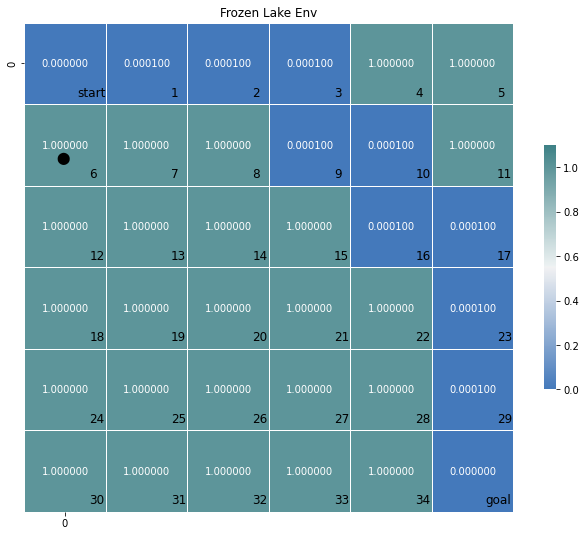

In [24]:
next_state, reward, has_episode_finished = frozen_lake.step(DOWN)
#print(next_state)
#print(reward)
print('has episode finished: ', has_episode_finished)
frozen_lake.render()
p_s_sprime_a, expected_r_s_sprime_a = frozen_lake.get_P_and_R_matrices(0, 0)
print('probability of transition at state = 0: ', p_s_sprime_a)
print('expected reward at state = 0 by action = LEFT: ', expected_r_s_sprime_a)
print('probable next states at state = 0: ', frozen_lake.get_probable_next_states(0))

## <span style="color:purple">Iterative Agent</span>

In [47]:
class IterativeAgent(ABC):
    def __init__(self, frozenLakeEnv, discount_factor):
        super(IterativeAgent, self).__init__()
        self.discount_factor = discount_factor
        self.frozenLakeEnv = frozenLakeEnv
        self.state_value = [0] * self.frozenLakeEnv.num_of_states
        self.state_action_value = np.zeros((self.frozenLakeEnv.num_of_states, len(self.frozenLakeEnv.action_space)))
        self.optimal_policy = [self.frozenLakeEnv.action_space] * self.frozenLakeEnv.num_of_states
        self.max_iterations = int(1e3)
        self.theta = 1e-3
        self.delta_values = []
        
        
    def get_optimal_policy(self):
        return self.optimal_policy
    

    def get_state_value(self):
        return self.state_value
    
    
    def get_state_action_value(self):
        return self.state_action_value
    
    
    def display_optimal_policy(self):
        f, ax = plt.subplots(figsize=(11, 9))
        cmap = seaborn.diverging_palette(220, 20, as_cmap=True)
        modified_state_value = np.round_([0] + self.state_value + [0], decimals=3)
        reshaped=np.reshape(modified_state_value,(self.frozenLakeEnv.observation_space.shape[0],self.frozenLakeEnv.observation_space.shape[1]))
        seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
                    square=True, xticklabels=self.frozenLakeEnv.observation_space.shape[0]+1, yticklabels=self.frozenLakeEnv.observation_space.shape[1]+1,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt=".3f")
        
        plt.text(0.65, 0.9, 'start', fontsize=12)
        plt.text(self.frozenLakeEnv.observation_space.shape[0]+0.65-1, self.frozenLakeEnv.observation_space.shape[1]+0.9-1, 'goal', fontsize=12)
        for state in range(1, self.frozenLakeEnv.num_of_states+1):
            x = state % self.frozenLakeEnv.observation_space.shape[1]
            y = state // self.frozenLakeEnv.observation_space.shape[1]
            plt.text(x+0.8, y+0.9, str(state), fontsize=12)
        
        for index in range(self.frozenLakeEnv.num_of_states):
            if not self.state_value[index] == 0:
                for action in self.optimal_policy[index]:
                    state = index + 1
                    i = state % self.frozenLakeEnv.observation_space.shape[1]
                    j = state // self.frozenLakeEnv.observation_space.shape[1]
                    if action==DOWN:
                        plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
                    elif action==UP:
                        plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
                    elif action==LEFT:
                        plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
                    elif action==RIGHT:
                        plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)

        plt.title('displaying V(s) and optimal policy')

## <span style="color:purple">Policy Iteration</span>

In [44]:
class PolicyIteration(IterativeAgent):
    def __init__(self, frozenLakeEnv, discount_factor):
        super(PolicyIteration, self).__init__(frozenLakeEnv, discount_factor)
        self.is_policy_stable = False
        self.old_state_value = [0] * self.frozenLakeEnv.num_of_states

        
    def policy_evaluation(self):
        for itr in range(self.max_iterations):
            delta = 0
            for state in range(self.frozenLakeEnv.num_of_states):
                if self.frozenLakeEnv.is_terminal_state(state+1):
                    continue
                
                self.old_state_value[state] = self.state_value[state]
                for action in self.optimal_policy[state]:
                    probable_next_states = self.frozenLakeEnv.get_probable_next_states(state+1)
                    p_s_sprime_a, expected_r_s_sprime_a = self.frozenLakeEnv.get_P_and_R_matrices(state+1, action)
                    summation = 0 
                    for next_state in probable_next_states:
                        if next_state == 0 or next_state == self.frozenLakeEnv.num_of_states+1:
                            delayed_reward = 0
                        else:
                            delayed_reward = self.discount_factor * self.state_value[next_state - 1]
                        index = probable_next_states.index(next_state)
                        summation += p_s_sprime_a[index] * (expected_r_s_sprime_a[index] + delayed_reward)

                    self.state_value[state] = sum(self.state_action_value[state,:])/len(self.state_action_value[state,:])
                    self.state_action_value[state, action] = summation
                delta = max(delta, abs(self.old_state_value[state] - self.state_value[state]))
            if delta<=self.theta: break
        self.delta_values.append(delta)
        #print('evaluation stoped at (%d)' % itr)
        
        
    def policy_improvement(self):
        old_policy = self.optimal_policy
        for state in range(self.frozenLakeEnv.num_of_states):
            max_item = max(self.state_action_value[state, :])
            optimal_actions = [index for index in range(len(self.state_action_value[state, :])) if self.state_action_value[state, index] == max_item]
            self.optimal_policy[state] = optimal_actions
        
        self.is_policy_stable = (old_policy == self.optimal_policy) and (self.old_state_value == self.state_value)
        
        
    def policy_iteration(self):
        itr = 0
        while not (self.is_policy_stable):
            self.policy_evaluation()
            self.policy_improvement()
            itr += 1
        print('policy iteration stopped at (%d)' % itr)
        
    
    def plot_convergence_of_policy_iteration(self):
        fig = plt.figure()
        plt.title("Convergence of Policy Iteration")
        plt.plot(range(len(self.delta_values)), self.delta_values)
        plt.xlabel('iteration')
        plt.ylabel('$\Delta$ = ||$V_k$ - $V_{k-1}$||$_{\infty}$')
        plt.grid()

policy iteration stopped at (28)


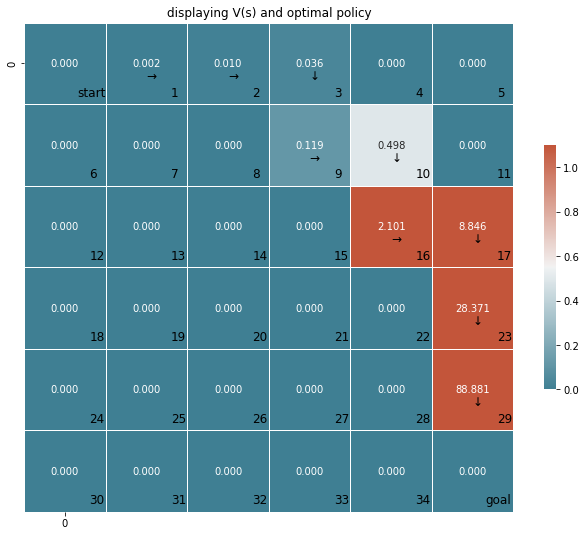

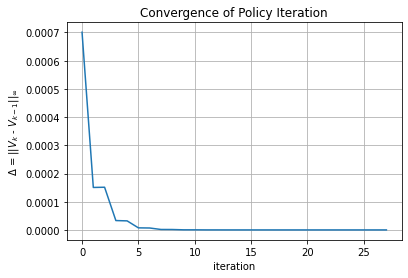

In [45]:
policy_it = PolicyIteration(frozen_lake, 0.9)
policy_it.policy_iteration()
#print(policy_it.get_optimal_policy())
#print(policy_it.get_state_value())
#print(policy_it.get_state_action_value())
policy_it.display_optimal_policy()
policy_it.plot_convergence_of_policy_iteration()

## <span style="color:purple">Value Iteration</span>

In [52]:
class ValueIteration(IterativeAgent):
    def __init__(self, frozenLakeEnv, discount_factor):
        super(ValueIteration, self).__init__(frozenLakeEnv, discount_factor)
        
        
    def value_iteration(self):
        for itr in range(self.max_iterations):
            delta = 0
            for state in range(self.frozenLakeEnv.num_of_states):
                if self.frozenLakeEnv.is_terminal_state(state+1):
                    continue
                    
                v = self.state_value[state]
                state_action_value_in_state = []
                for action in self.optimal_policy[state]:
                    probable_next_states = self.frozenLakeEnv.get_probable_next_states(state+1)
                    p_s_sprime_a, expected_r_s_sprime_a = self.frozenLakeEnv.get_P_and_R_matrices(state+1, action)
                    summation = 0 
                    for next_state in probable_next_states:
                        if next_state == 0 or next_state == self.frozenLakeEnv.num_of_states+1:
                            delayed_reward = 0
                        else:
                            delayed_reward = self.discount_factor * self.state_value[next_state - 1]
                        index = probable_next_states.index(next_state)
                        summation += p_s_sprime_a[index] * (expected_r_s_sprime_a[index] + delayed_reward)
                    state_action_value_in_state.append(summation)
                self.state_action_value[state] = state_action_value_in_state
                self.state_value[state] = max(state_action_value_in_state)
                delta = max(delta, abs(v - self.state_value[state]))
            self.delta_values.append(delta)
            if delta<=self.theta: break
        print('value iteration stoped at (%d)' % itr)
        
        for state in range(self.frozenLakeEnv.num_of_states):
            value_of_optimal_action = max(self.state_action_value[state][:])
            optimal_actions = []
            for action in self.optimal_policy[state]:
                if self.state_action_value[state][action] == value_of_optimal_action:
                    optimal_actions.append(action)
            self.optimal_policy[state] = optimal_actions
            
            
    def plot_convergence_of_value_iteration(self):
        fig = plt.figure()
        plt.title("Convergence of Value Iteration")
        plt.plot(range(len(self.delta_values)), self.delta_values)
        plt.xlabel('iteration')
        plt.ylabel('$\Delta$ = ||$V_k$ - $V_{k-1}$||$_{\infty}$')
        plt.grid()

value iteration stoped at (13)


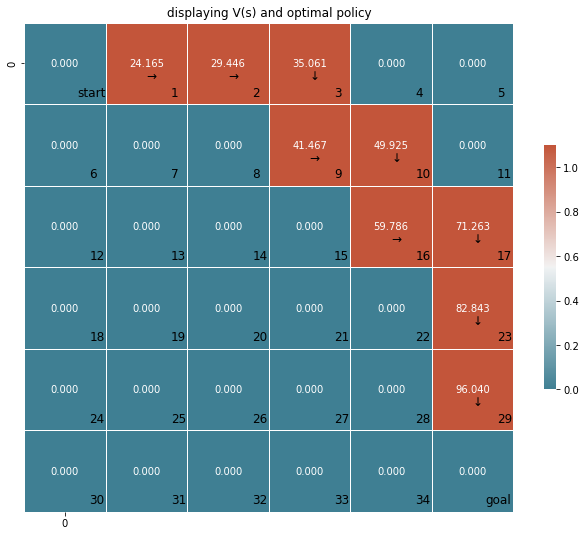

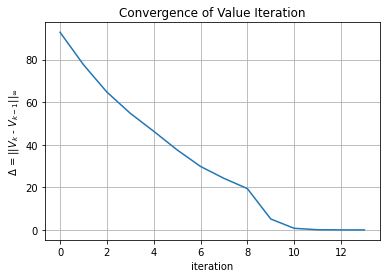

In [53]:
value_it = ValueIteration(frozen_lake, 0.9)
value_it. value_iteration()
#print(value_it.get_optimal_policy())
#print(value_it.get_state_value())
#print(value_it.get_state_action_value())
value_it.display_optimal_policy()
value_it.plot_convergence_of_value_iteration()